In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import utils

rcParams['figure.figsize'] = 14, 8

In [51]:
cam_data = pd.read_pickle('../traffic_data/raw_station_segment_data.pkl')
bus_data = pd.read_pickle('../traffic_data/raw_bus_data.pkl')
bus_data_coords = pd.read_pickle('../traffic_data/raw_data_with_corrigated_coords.pkl')
cam_data_month = pd.read_parquet('../traffic_data/raw_station_segment_data_2021-12-01_2022-01-01.parquet')
cam_data_month['timestamp'] = pd.to_datetime(cam_data_month['timestamp'], unit='s')

In [52]:
bus_data_coords = utils.preprocess_bus_data(bus_data_coords)
bus_data = utils.preprocess_bus_data(bus_data)
bus_data = utils.day_filter(bus_data,10)

In [53]:
scaler = MinMaxScaler()
train_data = utils.create_joined_cam_data(cam_data_month,9)
train_data = train_data.reset_index()
train_data = utils.thresholding(70,90,train_data,True)
train_data = train_data.drop(['timestamp'],axis=1)
train_data = train_data[train_data[['avg_speed', 'total_flow']].notnull().all(1)]
train_data = pd.DataFrame(scaler.fit_transform(train_data))

C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']
C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']


In [54]:
cam_data_joined = utils.create_joined_cam_data(cam_data_month,10)
cam_data_joined = cam_data_joined[cam_data_joined[['avg_speed', 'total_flow']].notnull().all(1)]
cam_data_joined = cam_data_joined.reset_index()
test_data = cam_data_joined.drop(['timestamp'],axis=1)
test_data = pd.DataFrame(scaler.fit_transform(test_data))

C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']
C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']


In [55]:
def create_model(input_dimension):
    input_layer = Input(shape=(input_dimension, ))
    encoder = Dense(input_dimension, activation="relu")(input_layer)
    decoder = Dense(input_dimension, activation='relu')(encoder)
    return Model(inputs=input_layer, outputs=decoder)

In [56]:
autoencoder = create_model(train_data.shape[1])

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
autoencoder.fit(train_data, train_data,
                    epochs=100,
                    batch_size=30,
                    shuffle=True,
                    verbose=1)

Epoch 1/100
48/48 [==============================] - 1s 2ms/step - loss: 0.0734 - accuracy: 0.5520
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0435 - accuracy: 0.7208
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.7208
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.7208
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0230 - accuracy: 0.7208
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.7208
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.7504
Epoch 8/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.7975
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.7982
Epoch 10/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.8059
Epoch 11/

In [57]:
prediction = autoencoder.predict(test_data)
measurement_error = np.mean(np.power(test_data - prediction, 2), axis=1)

57/57 [==============================] - 0s 1ms/step


In [58]:
threshold = 0.013
normal_data = cam_data_joined[cam_data_joined.index.isin(np.where(measurement_error < threshold)[0])]
outliers = cam_data_joined[cam_data_joined.index.isin(np.where(measurement_error > threshold)[0])]
len(outliers)

217

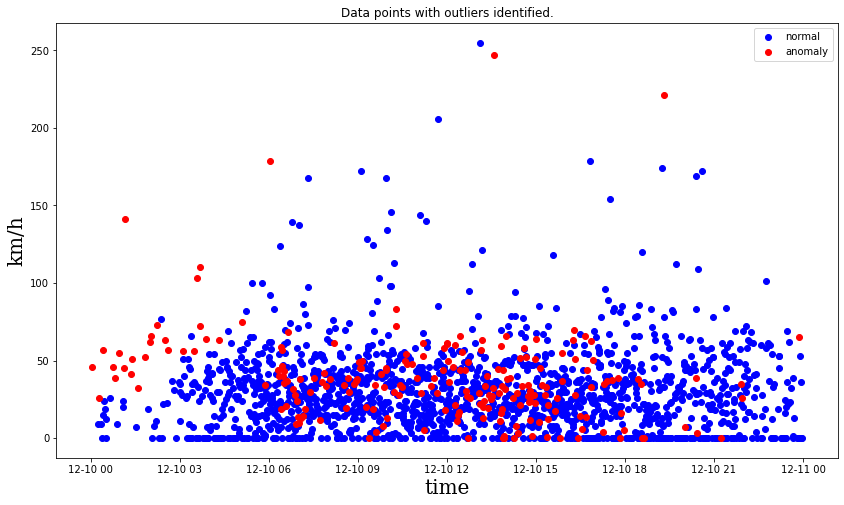

In [59]:
font = {'family':'serif','size':20}
plt.scatter(x=normal_data['timestamp'],y=normal_data['avg_speed'],color='b',label='normal')
plt.scatter(x=outliers['timestamp'],y=outliers['avg_speed'],color='r',label='anomaly')
plt.title("Data points with outliers identified.")
plt.xlabel("time",fontdict=font)
plt.ylabel("km/h",fontdict=font)
plt.legend()
plt.show()

<AxesSubplot:xlabel='timestamp'>

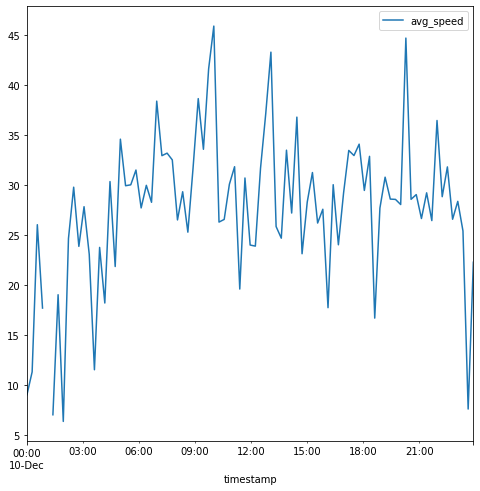

In [60]:
utils.resample(normal_data,'avg_speed',1000).plot.line(x='timestamp',y='avg_speed',figsize=(8,8))

In [61]:
plot_bus = utils.resample(bus_data,'velocity',1000)
plot_camera = utils.resample(normal_data,'avg_speed',1000)
plot_camera_before = utils.resample(cam_data,'avg_speed',1000)
plot_bus = plot_bus[plot_bus['velocity'] != 0]
plot_camera = plot_camera[plot_camera['avg_speed'] != 0]
plot_camera_before = plot_camera_before[plot_camera_before['avg_speed'] != 0]

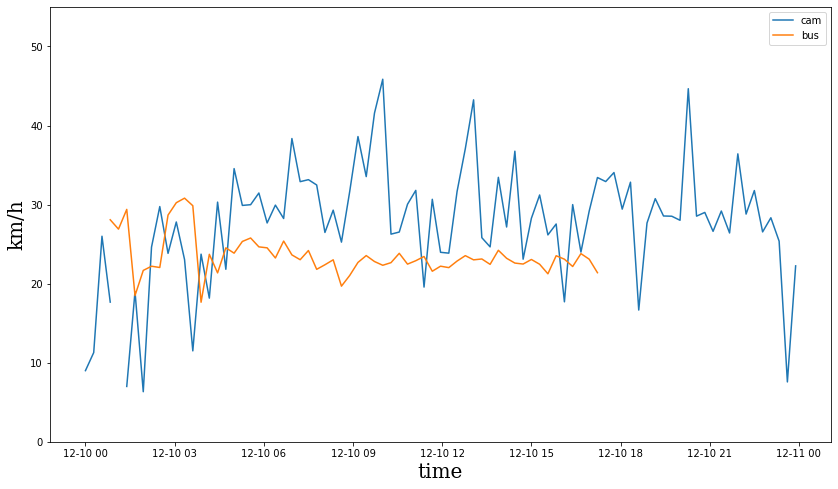

In [62]:
utils.two_line_plot(plot_bus,plot_camera)

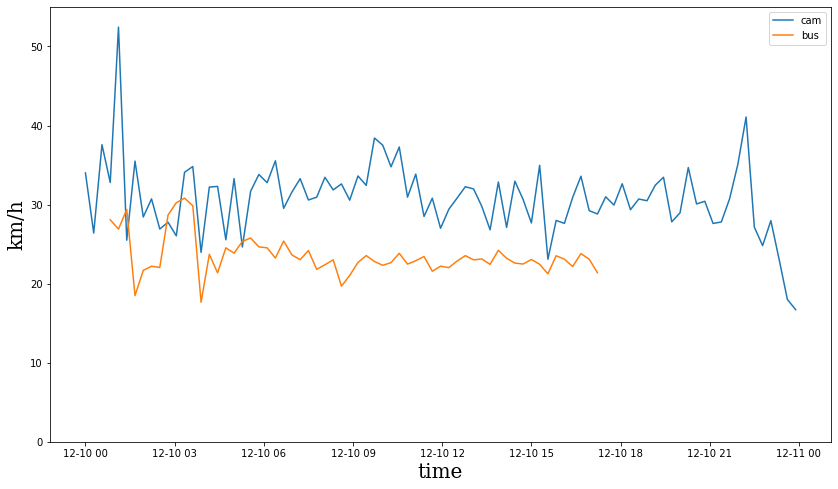

In [63]:
utils.two_line_plot(plot_bus,plot_camera_before)